<a href="https://colab.research.google.com/github/sieunrla03/quest_repo/blob/main/Titanic_sieun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240731%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240731T145543Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6a62fcc7650d37b1075ca0860d6fe2251da626a770bcf6dde21d3b53ff4a295d3b3dbcba471b186a9439b1ac48e9edff9f3ad1d1ba1711d827a73058efed4d24822434408535126c31e3c07dc44101febb53a7d80554dc05a0b9c3f24e3808c1b5504095f10e3fccb128a530749b099efe5f9f8d1f936b8704fb2fca79d35b31a7220b63fbe9d0507f8c404399340e402716269bb65a11a4d8c065f004d7727d0be93167ca30eef8e02b279a67a4396ff1950679cb3dc2ec8c4c0dc2e239fad68403985d83e9d57e38c4882038b624d0ec5f62c65a0d693a5d9d62aa420cbe856d5434d9ed3c616d50b05668da3e67b4895f3218d6801c8f15c6a403473f6242'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


생존여부 예측

## 라이브러리 설치 및 Data Overview

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [ ]:
# 결측치 확인
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

<Axes: >

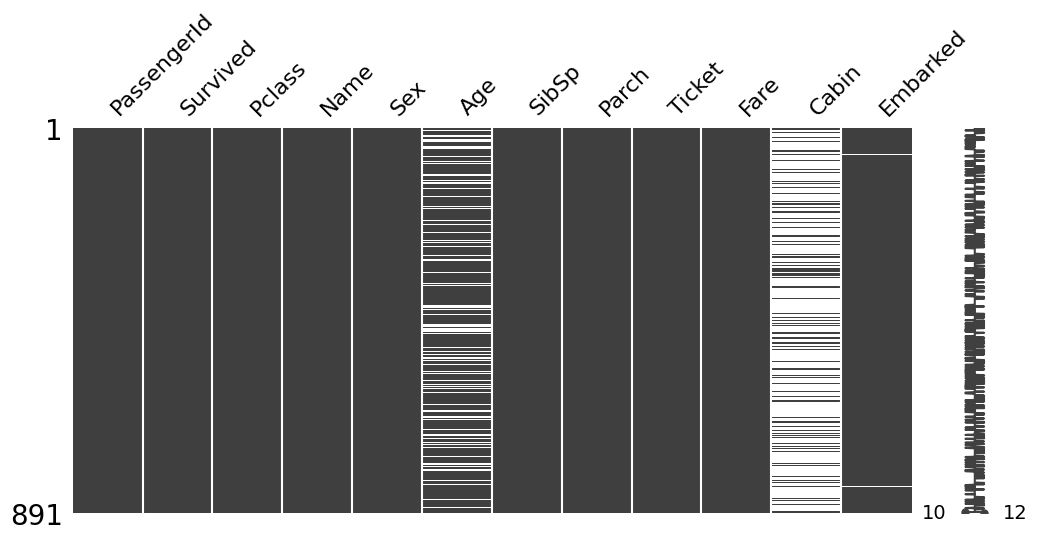

In [ ]:
# 결측치 처리
# 결측치 시각화
import missingno as msno
msno.matrix(train, figsize=(12,5))
# 결측치 보기에 좋은 라이브러리인듯!

## EDA
- Target data는 Survied

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/misc: caching, new cache contents: 89 fonts, 0 dirs
/usr/share/fonts/X11/util: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/share/fonts/type1: caching, n

In [ ]:
import matplotlib.font_manager as fm

# 시스템에 설치된 폰트 목록 확인
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
for font in font_list:
    if 'Nanum' in font or 'AppleGothic' in font or 'malgun' in font:
        print(font)

/usr/share/fonts/truetype/nanum/NanumSquareR.ttf
/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf
/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
/usr/share/fonts/truetype/nanum/NanumGothic.ttf
/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf


<Axes: ylabel='count'>

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing

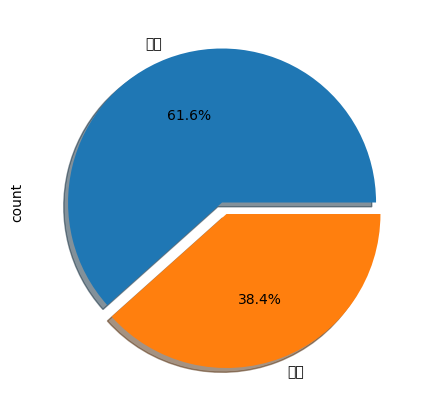

In [ ]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 생존비율 확인
train['Survived'].value_counts()

plt.figure(figsize=(8, 5))
labels = ['사망', '생존']
train['Survived'].value_counts().plot.pie(explode=[0, 0.08],
                                        shadow=True,
                                        autopct='%1.1f%%',
                                        labels=labels)

- 사망 비율은 61.6%, 생존 비율은 38.4%
- 사망한 탑승객의 수가 더 많은 것 확인

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53457 (\N{HANGUL SYLLABLE TAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-pack

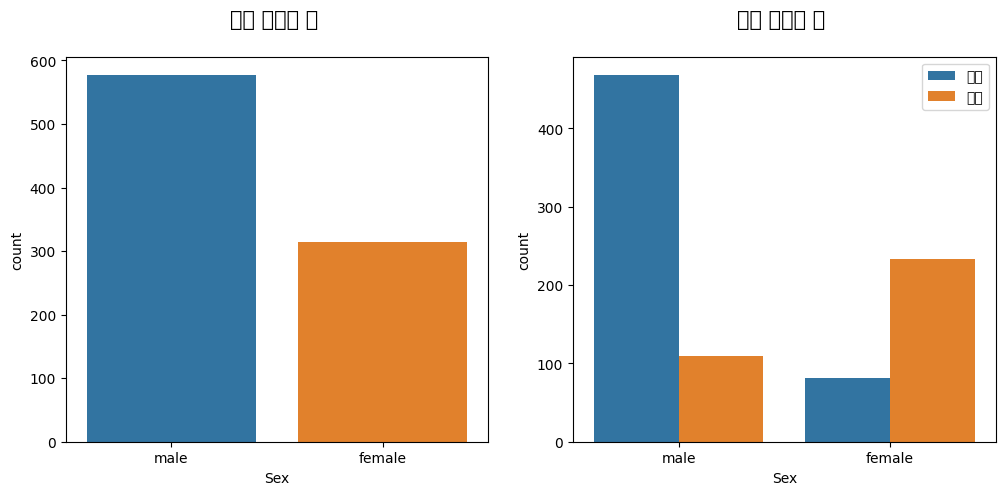

In [ ]:
# 성별 Sex
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title('성별 탑승자 수 \n', size = 15)
sns.countplot(x = 'Sex', data = train, ax = axes[0])

axes[1].set_title('성별 생존자 수 \n', size = 15)
sns.countplot(x = 'Sex', hue = 'Survived', data = train, ax = axes[1])
axes[1].legend(labels = ['사망', '생존'])

plt.show()


- 남성 탑승자 수가 여성 탑승자 수 보다 많음
- 하지만 생존비율은 여성이 더 높음

,Survived
Sex,
female,0.742038
male,0.188908


/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current fo

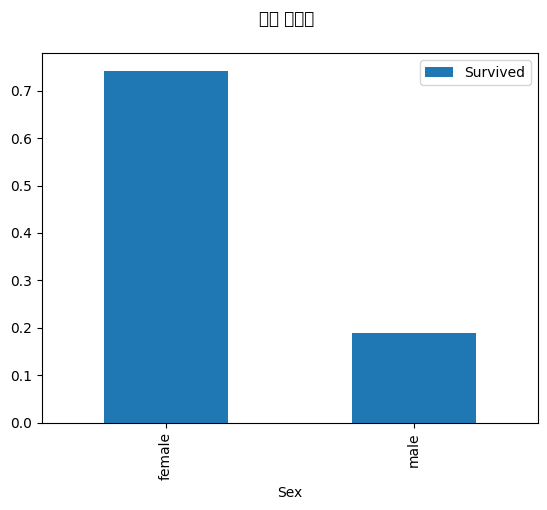

In [ ]:
# 성별에 따른 생존률 비교
sur = train[['Sex', 'Survived']].groupby('Sex').mean().plot.bar()
sur.set_title('성별 생존률 \n')
train[['Sex', 'Survived']].groupby('Sex').mean()

- 여성의 생존률은 약 74.2%, 남성 생존률은 약 18.9%
- 여성 생존률이 압도적으로 높음
    - 남성보다 여성을 먼저 구조한 것 예측
    - 영화에서도 여성과 어린아이를 먼저 구명정?에 타게함

### 티켓 클래스-Pclass

In [ ]:
# 티켓 클래스별로 생존률 확인
train[['Pclass', 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


- 1등석 생존률 약 63%
- 2등석 생존률 약 47%
- 3등석 생존률 약 24.2%

- 3등석 탑승객이 가장 많이 사망한 것으로 확인

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53457 (\N{HANGUL SYLLABLE TAB}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  fun

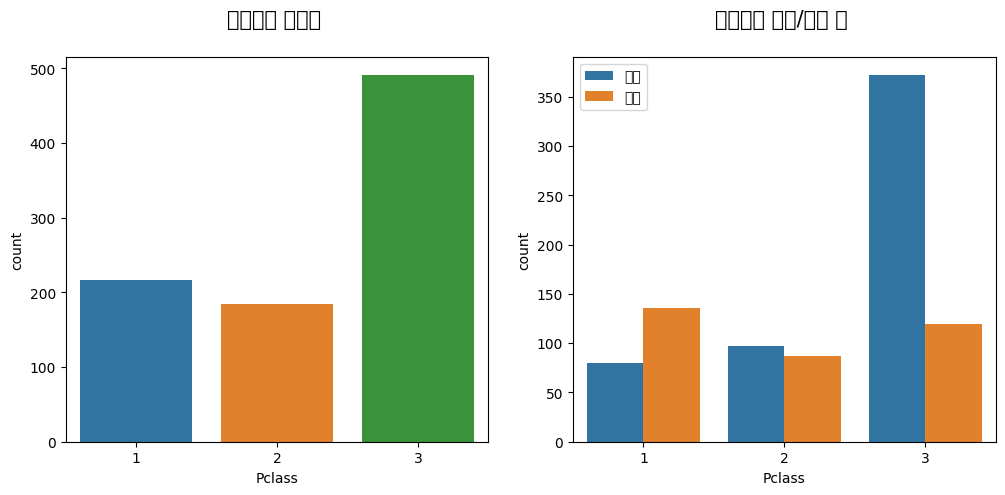

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title("클래스별 탑승수 \n", size=15)
sns.countplot(data=train, x='Pclass', ax=axes[0])

axes[1].set_title("클래스별 생존/사망 수 \n", size=15)
sns.countplot(x="Pclass", hue="Survived", data=train, ax=axes[1])
axes[1].legend(labels = ['사망', '생존'])

- 3등석 탑승객이 가장 많음
- 3등석 탑승객의 사망 인원수도 많음
- 상대적으로 1등석 탑승객 생존률이 높다고 할 수 있음

Text(0.5, 1.0, 'class별 생존률')

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) 

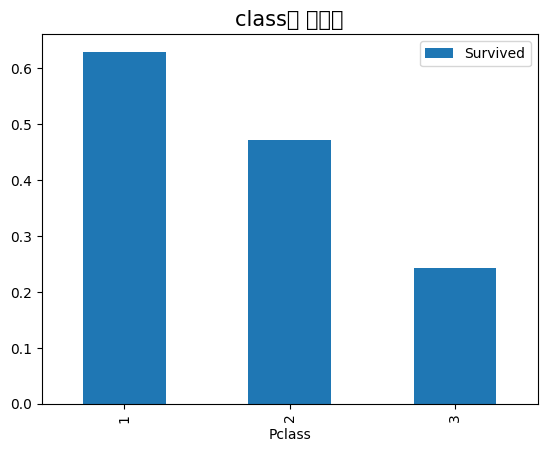

In [ ]:
# class별 생존률
sur = train[['Pclass', 'Survived']].groupby(['Pclass']).mean().plot.bar()
sur.set_title('class별 생존률', size=15)

- 1등석이 가장 높은 생존률을 보이고 3등석이 가장 낮은 생존률을 보임
- pclass도 생존 여부에 영향을 끼치는 것 같음

### 나이 - Age

In [ ]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

- 탑승객 평균 나이는 약 30세

/tmp/ipykernel_83/2982642578.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Age'], bins = 25)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Density'>

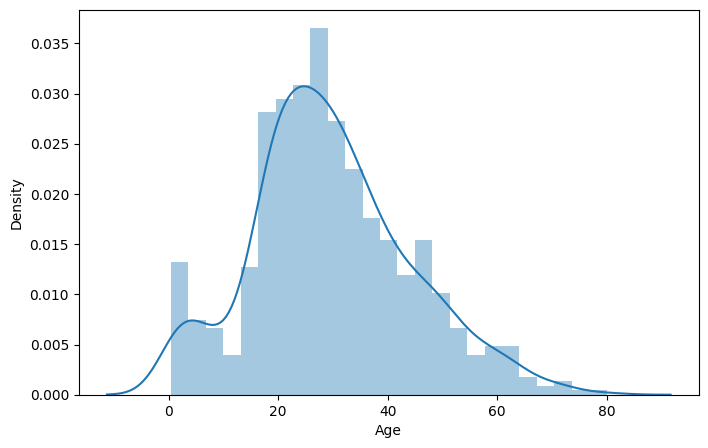

In [ ]:
plt.figure(figsize = (8, 5))
sns.distplot(train['Age'], bins = 25)

- 주로 20-40세 사이의 나이대로 분포

/tmp/ipykernel_83/4042824633.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sur['Age'], bins = 25, hist = False)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_83/4042824633.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level funct

<Axes: xlabel='Age', ylabel='Density'>

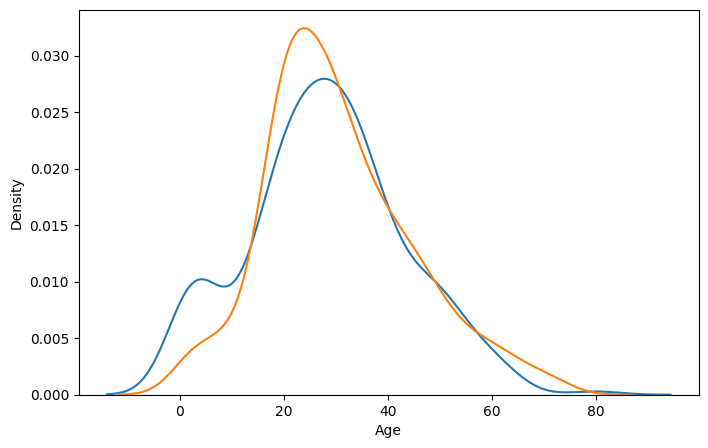

In [ ]:
# 나이가 생존여부에 영향을 끼지는지 확인
# 생존 / 사망 탑승객 비교
sur = train[train['Survived'] == 1]
dead = train[train['Survived'] == 0]

plt.figure(figsize = (8, 5))
sns.distplot(sur['Age'], bins = 25, hist = False)
sns.distplot(dead['Age'], bins = 25, hist = False)

- 어린 나이의 탑승객들의 생존률이 비교적 높음
- 20-30대 생존률은 비교적 낮음

### 함께 탑승한 가족 수 - SibSp, Parch

- SibSp : 함께 탑승한 형제자매, 배우자 수 총합
- Parch : 함께 탑승한 부모, 자녀 수 총합

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53457 (\N{HANGUL SYLLABLE TAB}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  func

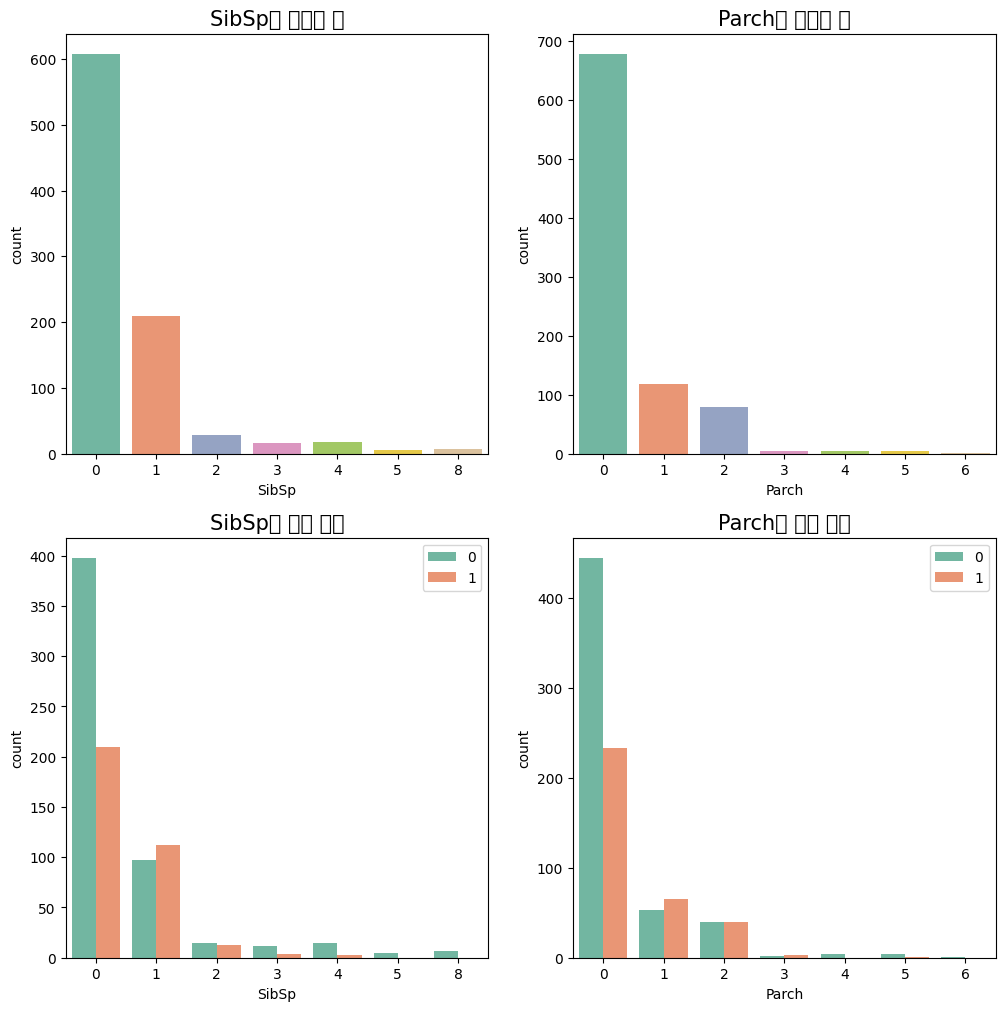

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0][0].set_title("SibSp별 탑승자 수", size=15)
sns.countplot(x="SibSp", data=train, ax=axes[0][0], palette="Set2")
axes[0][1].set_title("Parch별 탑승자 수", size=15)
sns.countplot(x="Parch", data=train, ax=axes[0][1], palette="Set2")

axes[1][0].set_title("SibSp별 생존 여부", size=15)
sns.countplot(x="SibSp", hue="Survived", data=train, ax=axes[1][0], palette="Set2")
axes[1][0].legend(loc='upper right')
axes[1][1].set_title("Parch별 생존 여부", size=15)
sns.countplot(x="Parch", hue="Survived", data=train, ax=axes[1][1], palette="Set2")
axes[1][1].legend(loc='upper right')

In [ ]:
def bar_chart(feature):
    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

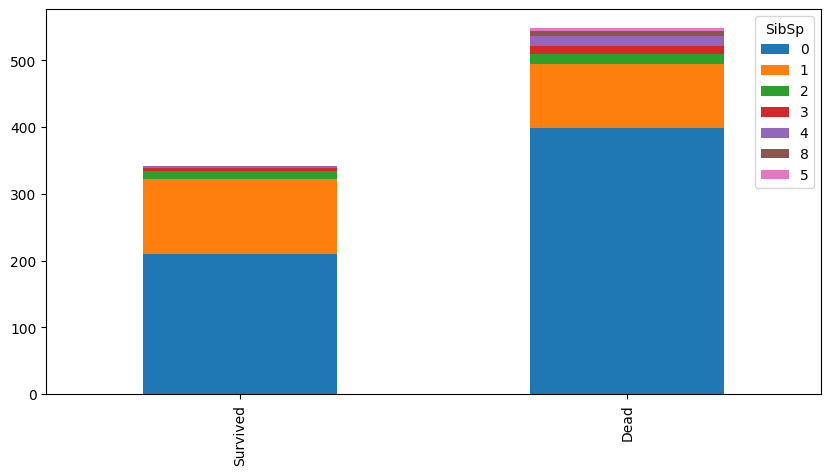

In [ ]:
bar_chart("SibSp")

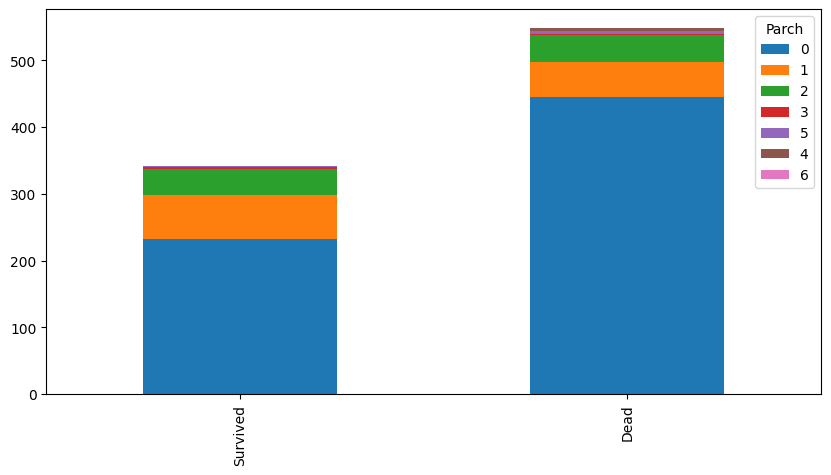

In [ ]:
bar_chart("Parch")

In [ ]:
train[['SibSp', 'Survived']].groupby(['SibSp']).mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [ ]:
train[['Parch', 'Survived']].groupby(['Parch']).mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


- 혼자 탑승한 승객이 가장 많음
- 생존 여부도 혼자 탑승한 승객이 가장 많이 사망함
- SibSp - 2명 이상의 형제나 배우자와 함께 탔을 경우 생존한 사람의 비율이 높다는 것
- Parch - 부모, 자녀 없이 혼자 탑승한 사람의 사망률이 가장 높다

### 탑승 항구 - Embarked

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53457 (\N{HANGUL SYLLABLE TAB}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func

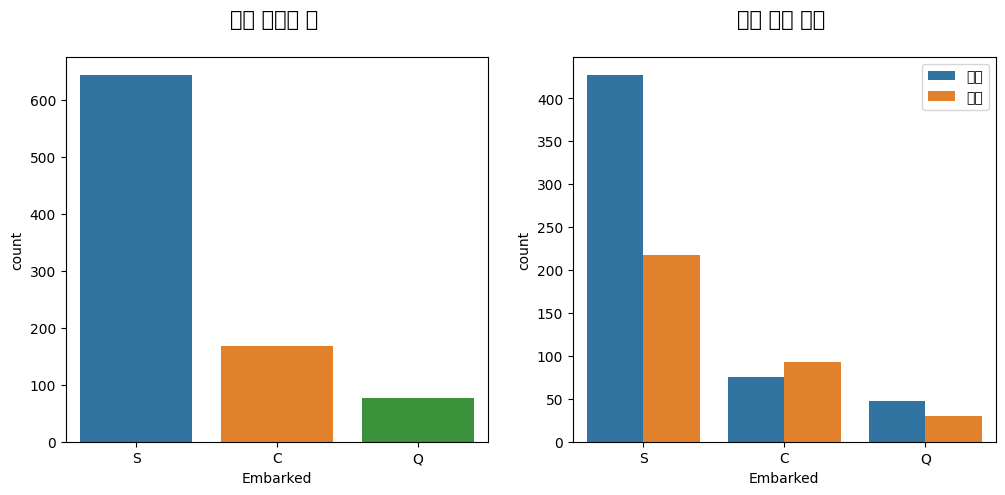

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title("성별 탑승자 수 \n", size=15)
sns.countplot(x="Embarked", data=train, ax=axes[0])

axes[1].set_title("성별 생존 여부 \n", size=15)
sns.countplot(x="Embarked", hue="Survived", data=train, ax=axes[1])
axes[1].legend(labels = ['사망', '생존'])

- S항구 탑승객이 가장 많음
- 사망한 인원 역시 S항구 탑승객이 가장 많음

In [ ]:
# 항구별 사망 비율
train[['Embarked', 'Survived']].groupby(['Embarked']).mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


- S항구 탑승객 사망률 가장 높음

## 항구별 탑승객들의 티켓 클래스

<Axes: >

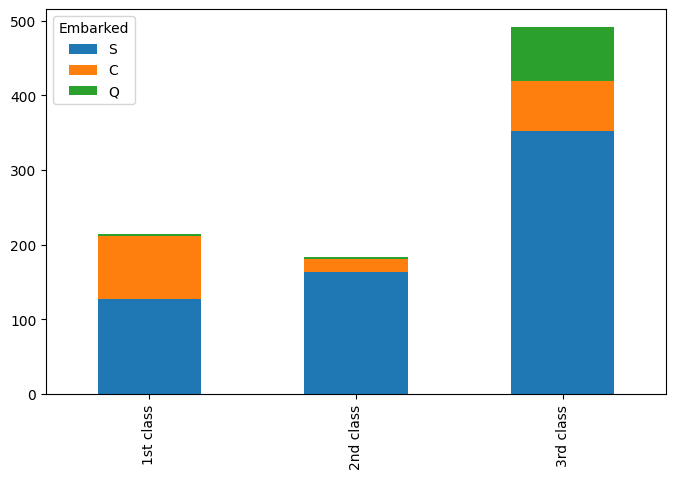

In [ ]:
pc1 = train[train['Pclass'] == 1]['Embarked'].value_counts()
pc2 = train[train['Pclass'] == 2]['Embarked'].value_counts()
pc3 = train[train['Pclass'] == 3]['Embarked'].value_counts()
pc = pd.DataFrame([pc1, pc2, pc3])
pc.index = ['1st class', '2nd class', '3rd class']

fig, ax = plt.subplots(figsize=(8, 5))
pc.plot(kind='bar', stacked=True, ax=ax)

- 3등석에 S항구 탑승객이 많음
- 3등석의 사망률이 가장 높았으므로 3등석에 S항구 탑승객들이 많아서 S항구 탑승객들의 사망률이 높음

### 항구별 탑승객들의 동승자

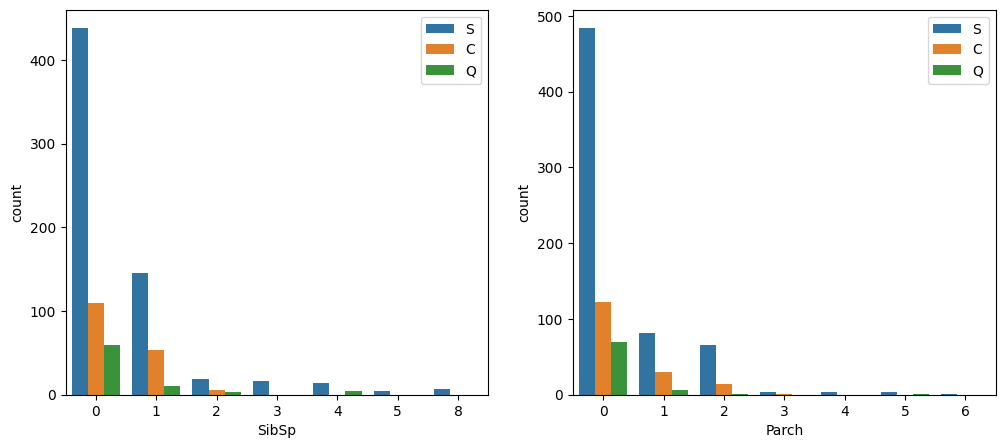

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(data=train, x='SibSp', hue='Embarked', ax=ax[0])
sns.countplot(data=train, x='Parch', hue='Embarked', ax=ax[1])
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
plt.show()

- 혼자 탑승한 탑승객의 수는 S항구 탑승객이 압도적

### 탑승 금액 - Fare

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Gly

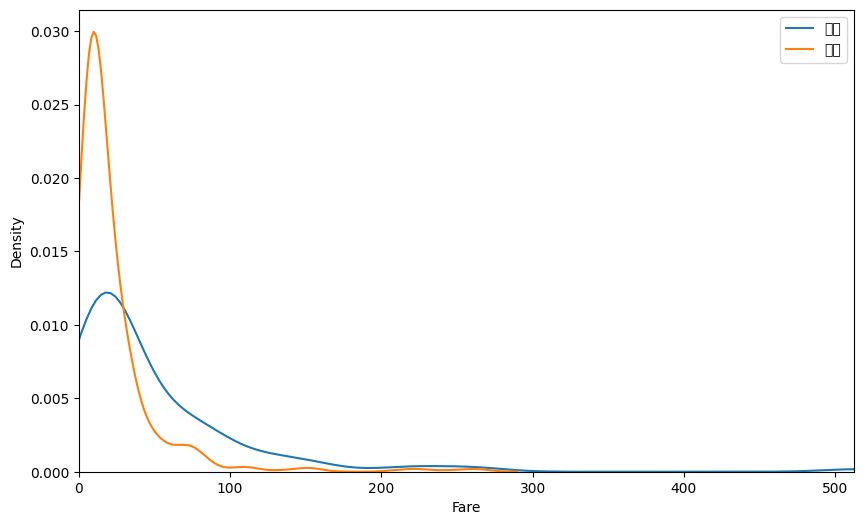

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

# 분포 확인
sns.kdeplot(train[train['Survived']==1]['Fare'], ax=ax)
sns.kdeplot(train[train['Survived']==0]['Fare'], ax=ax)

# 축 범위
ax.set(xlim=(0, train['Fare'].max()))
ax.legend(['생존', '사망'])

plt.show()

- 탑승 금액이 적은 쪽은 사망률이 높음 확인
- 탑승 클래스, 탑승 금액이 생존 여부에 영향을 끼치는 것으로 생각듦
    - 3등석에서 사망률이 높았으니 탑승 금액 영향이 있는 것이 당연하지

## Feature Engineering
- 상관계수, 결측치 확인 먼저 하자

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
data_list = [train, test]

### 결측치 처리

In [ ]:
# 성별은 남성, 여성으로 나누어 이를 0,1로 바꾸자
for data in data_list:
    data['Sex'] = data['Sex'].astype('category').cat.codes


In [ ]:
train['Sex'].head()

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int8

In [ ]:
# Age 컬럼에 177개 결측치 존재
# 평균으로 채우기로 결정
sex_mean = train.groupby('Sex')['Age'].mean()
sex_mean

Sex
0    27.915709
1    30.726645
Name: Age, dtype: float64

In [ ]:
# 남성 평균 31세, 여성 평균 28세
# Age 결측치 처리
for data in data_list:
    data.loc[(data['Sex'] == 0) & (data['Age'].isnull()), 'Age'] = sex_mean[0]
    data.loc[(data['Sex'] == 1) & (data['Age'].isnull()), 'Age'] = sex_mean[1]

train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
# 카테고리화
train['AgeRange'] = pd.cut(train['Age'], 5)
train[['AgeRange', 'Survived']].groupby(['AgeRange']).mean()

/tmp/ipykernel_83/452087332.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train[['AgeRange', 'Survived']].groupby(['AgeRange']).mean()


,Survived
AgeRange,
"(0.34, 16.336]",0.550000
"(16.336, 32.252]",0.344168
"(32.252, 48.168]",0.404255
"(48.168, 64.084]",0.434783
"(64.084, 80.0]",0.090909


In [ ]:
for data in data_list:
    data.loc[ data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age'] = 4
train.drop('AgeRange', inplace=True, axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,2.0,0,0,373450,8.0500,NaN,S


In [ ]:
#Name
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

- master까지가 제일 많이 있어서 이 외의 나머지는 other로 바꿔주기

In [ ]:
for data in data_list:
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    data['Title'] = data['Title'].replace(['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess',
                                        'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'], 'Other')
    # -> 범주형 -> 수치형
    data['Title_name'] = data['Title'].astype('category').cat.codes

In [ ]:
train[['Title', 'Survived']].groupby(['Title']).mean()

,Survived
Title,
Master,0.575000
Miss,0.697802
Mr,0.156673
Mrs,0.792000
Other,0.444444


In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_name
0,1,0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,0,PC 17599,71.2833,C85,C,Mrs,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2.0,1,0,113803,53.1000,C123,S,Mrs,3
4,5,0,3,"Allen, Mr. William Henry",1,2.0,0,0,373450,8.0500,NaN,S,Mr,2


In [ ]:
# 불필요한 데이터 지우기
train.drop(['Name', 'Title'], axis=1, inplace = True)
test.drop(['Name', 'Title'], axis=1, inplace = True)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_name
0,1,0,3,1,1.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,0,2.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,0,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,0,2.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,1,2.0,0,0,373450,8.0500,NaN,S,2


In [ ]:
# SibSp + Parch
# 혼자 탑승한 탑승객과 그 외의 탑승객의 사망률에 차이가 있었기 때문에 가족이라는 새로운 컬럼을 만들자
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_name,FamilySize
0,1,0,3,1,1.0,1,0,A/5 21171,7.2500,NaN,S,2,2
1,2,1,1,0,2.0,1,0,PC 17599,71.2833,C85,C,3,2
2,3,1,3,0,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,1,0,2.0,1,0,113803,53.1000,C123,S,3,2
4,5,0,3,1,2.0,0,0,373450,8.0500,NaN,S,2,1


<Axes: xlabel='FamilySize', ylabel='count'>

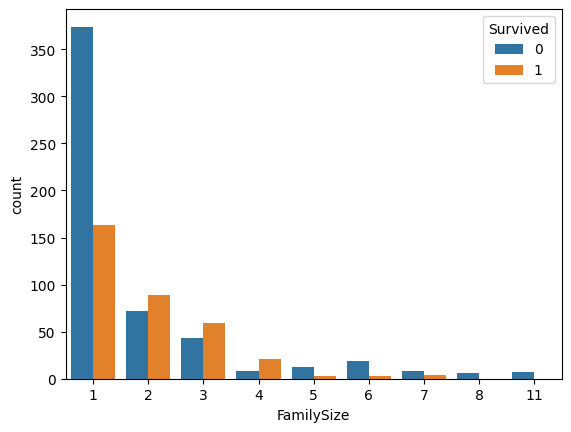

In [ ]:
# 피봇 테이블로 가족수별 생존률 확인하고 시각화
pd.pivot_table(train, index='FamilySize', values='Survived')
sns.countplot(data=train, x='FamilySize', hue='Survived')

In [ ]:
# FamilySize라는 컬럼을 만들어주었으므로 이제 필요 없는 'SibSp', 'Parch' 컬럼을 제거
drop_list = ['SibSp', 'Parch']
for data in data_list:
    data.drop(drop_list, inplace=True, axis=1)

In [ ]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title_name       0
FamilySize       0
dtype: int64

In [ ]:
# Embarked 결측치
# 2개 밖에 없으니까 가장 비율 많았던 S로 채워주기
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

<Axes: xlabel='Embarked', ylabel='count'>

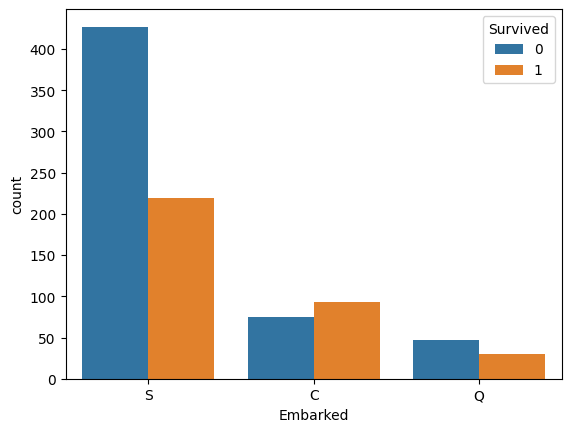

In [ ]:
for data in data_list:
    data['Embarked'] = data['Embarked'].fillna('S')
sns.countplot(data=train, x='Embarked', hue='Survived')

- C 항구에서 탄 승객들의 생존률이 비교적 높음

In [ ]:
# 0,1,2로 매핑
em_mapping = {'S':0, 'C':1, 'Q':2}
for data in data_list:
    data['Embarked'] = data['Embarked'].map(em_mapping)

In [ ]:
# cabin은 선실
# 결측치가 비교적 좀 많은편
train['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [ ]:
for data in data_list:
    data['Cabin'] = data['Cabin'].fillna('N')
    data['Cabin'] = data['Cabin'].apply(lambda x:x[0])
    data['Cabin'] = data['Cabin'].astype('category').cat.codes
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title_name,FamilySize
0,1,0,3,1,1.0,A/5 21171,7.2500,7,0,2,2
1,2,1,1,0,2.0,PC 17599,71.2833,2,1,3,2
2,3,1,3,0,1.0,STON/O2. 3101282,7.9250,7,0,1,1
3,4,1,1,0,2.0,113803,53.1000,2,0,3,2
4,5,0,3,1,2.0,373450,8.0500,7,0,2,1


- 결측치는 N으로 채우기
- 각각 맨 앞자리의 알파벳으로 불러오기
- 수치형으로 변경

In [ ]:
# 필요 없는 칼럼 삭제
drop_list = ['PassengerId', 'Ticket']
for data in data_list:
    data.drop(drop_list, inplace=True, axis=1)

for data in data_list:
    data.drop('Cabin', inplace=True, axis=1)

In [ ]:
# Test data 결측치 처리
test[test['Fare'].isnull()] = test['Fare'].mean()

/tmp/ipykernel_83/4180455066.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.627188489208635' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test[test['Fare'].isnull()] = test['Fare'].mean()
/tmp/ipykernel_83/4180455066.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.627188489208635' has dtype incompatible with int8, please explicitly cast to a compatible dtype first.
  test[test['Fare'].isnull()] = test['Fare'].mean()
/tmp/ipykernel_83/4180455066.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.627188489208635' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test[test['Fare'].isnull()] = test['Fare'].mean()
/tmp/ipykernel_83/4180455066.py:

In [ ]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title_name,FamilySize
0,0,3,1,1.0,7.2500,0,2,2
1,1,1,0,2.0,71.2833,1,3,2
2,1,3,0,1.0,7.9250,0,1,1
3,1,1,0,2.0,53.1000,0,3,2
4,0,3,1,2.0,8.0500,0,2,1


In [ ]:
test.head()

,Pclass,Sex,Age,Fare,Embarked,Title_name,FamilySize
0,3.0,1.0,2.0,7.8292,2.0,3.0,2.0
1,3.0,0.0,2.0,7.0000,0.0,4.0,2.0
2,2.0,1.0,3.0,9.6875,2.0,3.0,1.0
3,3.0,1.0,1.0,8.6625,0.0,3.0,2.0
4,3.0,0.0,1.0,12.2875,0.0,4.0,1.0


In [ ]:
train.corr()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title_name,FamilySize
Survived,1.000000,-0.338481,-0.543351,-0.043800,0.257307,0.106811,-0.052471,0.016639
Pclass,-0.338481,1.000000,0.131900,-0.358769,-0.549500,0.045702,-0.195910,0.065997
Sex,-0.543351,0.131900,1.000000,0.070220,-0.182333,-0.116569,0.040484,-0.200988
Age,-0.043800,-0.358769,0.070220,1.000000,0.123640,-0.051334,0.427999,-0.217063
Fare,0.257307,-0.549500,-0.182333,0.123640,1.000000,0.062142,-0.009068,0.217138
Embarked,0.106811,0.045702,-0.116569,-0.051334,0.062142,1.000000,-0.081928,-0.080281
Title_name,-0.052471,-0.195910,0.040484,0.427999,-0.009068,-0.081928,1.000000,-0.207530
FamilySize,0.016639,0.065997,-0.200988,-0.217063,0.217138,-0.080281,-0.207530,1.000000


## Model

In [ ]:
train_input = train.drop('Survived', axis=1).values
train_target = train['Survived'].values
print(train_input.shape, train_target.shape)  #(891, 7) (891,)

(891, 7) (891,)


In [ ]:
# 라이브러리
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
# KNN
model = KNeighborsClassifier()
score = cross_validate(model, train_input, train_target,
                      return_train_score=True, n_jobs=-1,
                      cv = StratifiedKFold())
print(np.mean(score['train_score']), np.mean(score['test_score']))

0.8361417968072867 0.7621618228610885


In [ ]:
# Decision Tree
model = DecisionTreeClassifier()
score = cross_validate(model, train_input, train_target,
                      return_train_score=True, n_jobs=-1,
                      cv = StratifiedKFold())
print(np.mean(score['train_score']), np.mean(score['test_score']))

0.9475294293773737 0.7946644906157805


In [ ]:
# Random Forest
model = RandomForestClassifier()
score = cross_validate(model, train_input, train_target,
                      return_train_score=True, n_jobs=-1,
                      cv = StratifiedKFold())
print(np.mean(score['train_score']), np.mean(score['test_score']))

0.9475294293773737 0.8036093151716779


In [ ]:
# GradientBoosting
model = GradientBoostingClassifier()
score = cross_validate(model, train_input, train_target,
                      return_train_score=True, n_jobs=-1,
                      cv = StratifiedKFold())
print(np.mean(score['train_score']), np.mean(score['test_score']))

0.9009522196132813 0.8339338396836358


In [ ]:
# HistGradientBoosting
model = HistGradientBoostingClassifier()
score = cross_validate(model, train_input, train_target,
                      return_train_score=True, n_jobs=-1,
                      cv = StratifiedKFold())
print(np.mean(score['train_score']), np.mean(score['test_score']))

0.9194718470775486 0.8395329860021341


In [ ]:
# Naive Bayes
model = GaussianNB()
score = cross_validate(model, train_input, train_target,
                      return_train_score=True, n_jobs=-1,
                      cv = StratifiedKFold())
print(np.mean(score['train_score']), np.mean(score['test_score']))

0.8089237593961265 0.8081036971941498


In [ ]:
# Support Vector Machine
model = SVC()
score = cross_validate(model, train_input, train_target,
                      return_train_score=True, n_jobs=-1,
                      cv = StratifiedKFold())
print(np.mean(score['train_score']), np.mean(score['test_score']))

0.6798611658288289 0.6678865105768628


In [ ]:
model = HistGradientBoostingClassifier()
model.fit(train_input, train_target)
test_input = test.values
pred = model.predict(test_input)

submission['Survived'] = pred
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
submission.to_csv('submission_result.csv', index=False)

In [ ]:
result = pd.read_csv('/kaggle/working/submission_result.csv')

In [ ]:
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


- https://seo00.tistory.com/61 참고
- 왜 채점이 안될까...ㅜ..
- 모델들 중에 처음보는 것들이 많다 이런 부분을 알아보기